In [1]:
import sys
sys.path.append("/home/bl9/gempy/")
sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         #path_f = "/home/bl9/gempy//input_data/Fab_TrapModel_Foliations.csv",
                         #path_i = "/home/bl9/gempy//input_data/Fab_TrapModel_Points.csv")
                         path_f = "./input_data/FabLessPoints_Foliations.csv",
                         path_i = "./input_data/FabLessPoints_Points1.csv")
geo_data.n_faults = 1

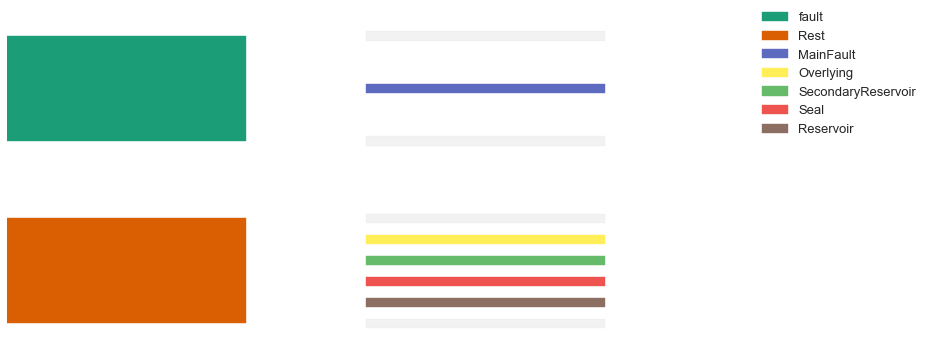

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Reservoir', 'Seal', 'SecondaryReservoir', 'Overlying')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'Overlying', 'SecondaryReservoir', 'Seal','Reservoir',
                                         ])

In [51]:
#geo_data.set_formation_number(['MainFault','Reservoir','Seal','SecondaryReservoir','Overlying'])

In [7]:
#gp.data_to_pickle(geo_data, 'BasicFault') #saving data to pickle

In [8]:
#geo_data.interfaces.head()
#gp.get_data(geo_data)

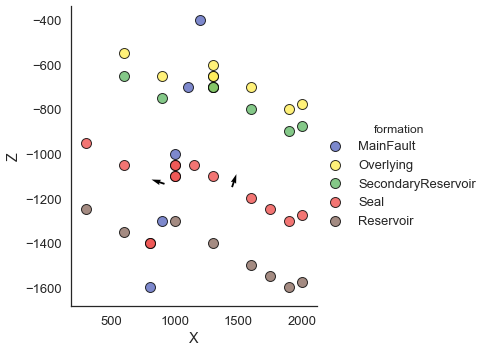

In [4]:
gp.plot_data(geo_data)

In [158]:
gp.plot_data_3D(geo_data)

In [5]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [6]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [7]:
# CREATING SURFACES FOR LAYERS
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Reservoir']))
overlying_surf, overlying_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Overlying']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['SecondaryReservoir']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Seal']))

In [111]:
#geo_data.get_formation_number().keys()

In [112]:
#geo_data.get_formations()

In [10]:
geo_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 2,
 'Reservoir': 5,
 'Seal': 4,
 'SecondaryReservoir': 3}

In [11]:
#opacity = float(1)
gp.plot_surfaces_3D(geo_data, [overlying_surf, sec_res_surf, seal_surf, res_surf], 
                    [overlying_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=True)

In [186]:
#sys.path.append("/home/bl9/gempy/gempy/")
#
#import Visualization 
#importlib.reload(Visualization)

<module 'Visualization' from '/home/bl9/gempy/gempy/Visualization.py'>

In [189]:
#w = Visualization.vtkVisualization(interp_data.geo_data_res, real_time=True )
#w.set_surfaces([overlying_surf, sec_res_surf, seal_surf, res_surf], 
#               [overlying_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp],
#               #formations_names_l, formation_numbers_l,
#                )
#w.interp_data  = interp_data
#if True:
#    w.set_interfaces()
#    w.set_foliations()
#w.render_model()

In [79]:
gp.plot_surfaces_3D(geo_data, [res_surf], [res_surf_simp])

In [12]:
interp_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 2,
 'Reservoir': 5,
 'Seal': 4,
 'SecondaryReservoir': 3}

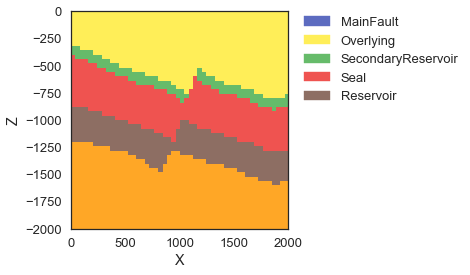

In [13]:
#%matplotlib notebook
%matplotlib inline
gp.plot_section(geo_data, lith_sol[0,0], 25) #plot_data=True)

In [8]:
resolution = 50
model_size = 2000
scale_factor = (model_size/resolution) #original grid in [m]/grid resolution --> what if model not cubic?

In [9]:
# SPILL AND LEAK POINT FUNCTIONS

# Finding the spill point
def spill_point(res_surface):
    mini = argrelextrema(res_surface[:,2], np.less, order=10)
    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
    spill_min_line = minima[fault_thresh]
    spill_pos = np.array(np.argmax(spill_min_line[:,2]))
    spill_z = np.take(spill_min_line[:,2], spill_pos)
    spill_p = np.array([np.take(spill_min_line[:,1], spill_pos), np.take(spill_min_line[:,0],
                                spill_pos), np.take(spill_min_line[:,2], spill_pos)])
    
    # Horizontal plane defined by z-pos of spill
    if True:
        spill_bottom = np.ones_like(res_surface)
        spill_bottom[:,0] = res_surface[:,0]
        spill_bottom[:,1] = res_surface[:,1]
        spill_bottom[:,2] = spill_z    
    
    return spill_z, spill_p, spill_min_line, spill_bottom

# Finding the leak point ( critically inefficient method! takes 10s!)
def leak_point(res_surface):
    counter = 0
    # Creating empty lists and arrays to save values
    xvals = []
    yvals = []
    zvals = []
    leak_min = np.empty((0,3), dtype=int)
    #leak_min = np.empty([3,], dtype=int)
    
    for i in np.unique(res_surface[:,1]):
        
    #while counter < model_size:
        #print(counter)
        for e in res_surface:
            # Looking at a slice along y-axis for y = e[1] = counter, 
            # and appending x,y,z-values into lists
            # This is a way of RESORTING the array as needed
            #if int(e[1]) == counter:
            if e[1] == i:
                xvals.append(e[0])
                yvals.append(e[1])
                zvals.append(e[2])
            
        # Saving x,y,z-values as lists/arrays      
        zvals = np.array(zvals)
        yvals = np.array(yvals)
        xvals = np.array(xvals)

        # Looking fore minima positions in z-array
        min_pos = argrelextrema(zvals, np.less, order=10)
        
        # Saving x,y,z-positions of minima
        ypos = yvals[min_pos]
        xpos = xvals[min_pos]
        mins = zvals[min_pos]
        
        # Condition: Check if any minimum was found and if any data is given at y = counter
        # If no minimum found, restart loop at next iteration
        # This way, we can work with the data that coesn't cover every 1 step along the model
        # (such as the surface vertices)
        if len(mins) == 0:
            counter += 1
            #lists have to be emptied again
            xvals = []
            yvals = []
            zvals = []
            continue
        
        #np.append(leak_min, mins) -----> what did I use this for?
        
        # Create and array element to save coordinates of minima
        mins_pos = np.array(list(zip(xpos, ypos, mins)))
        # Save minima of slice into array of ALL minima
        leak_min = np.vstack((leak_min, mins_pos))

        # Empty lists for next iteration
        xvals = []
        yvals = []
        zvals = []
    
        counter += 1
        
    #leak_min = np.delete(leak_min, 0, 0) #what does this do???
    
    # Result of the loop above is one or SEVERAL lines of minima ("leak lines")
    # only want to look at the line bordering the fault surface
    # need for a general function/method to limit to only that line!
    # For now: Taking only relevant side by setting a threshold that is visually estimated
    near_fault_thresh = leak_min[:,0] < 1500
    leak_line = leak_min[near_fault_thresh]
    
    # The highest point of the leak line is the leak point!
    leak_pos = np.array(np.argmax(leak_line[:,2]))
    leak_z = np.take(leak_line[:,2], leak_pos)

    # Full coordinates of the leak point as array element
    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
    
    # Creating a horizontal plane defined by the leak point z-position, in shape of res_surface
    leak_bottom = np.ones_like(res_surface)
    leak_bottom[:,0] = res_surface[:,0]
    leak_bottom[:,1] = res_surface[:,1]
    leak_bottom[:,2] = leak_z
   
    return leak_z, leak_p, leak_line, leak_bottom

In [10]:
# MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = bottom_z/scale_factor
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to the overlying seal 
# (the voxels is located on the border of reservoir and seal):
def set_spill_to_seal(geo_data, lith, max_z):
    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]+np.abs(max_z)))
    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
    lith[bol_lith_spill] = 6
    return lith
        ### Hpw to check in here, if single spill voxel = reservoir (5)??? Need x and y pos?

# Masking that confines the volume to ONLY those reservoir traps (from res_mask)
# that are NOT connected to the borders of the model (open system)
# Traps defined as CLOSED systems
def topo_analysis(lith, fault):
    fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad)
    #topo.draw_section(25)
    topo_block = topo.labels
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    topo_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()]
    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()]
    #over_keys = [int(o) for o in topo.lith_to_labels_lot["2"].keys()]
    #sec_res_keys = [int(sr) for sr in topo.lith_to_labels_lot["3"].keys()]
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in topo_keys:
        print('Checking Section:', tk)
        # Saving enclosed sections as traps
        if topo.check_adjacency(tk, pad_keys[0]) == False:
            print("TRAP FOUND, section:", tk)
            traps.append(tk)
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
            ### Extra check for juxtaposition with layers above seal
            #if topo.check_adjacency(i, over_keys[0]) == False and topo.check_adjacency(i, sec_res_keys[0]) == False:
            #    print('Trap sealed upwards.')
            #    top_bool = topo_block == i
            #    bool_block[top_bool] = True
            #else: 
            #    print("Juxtaposition, no trap sealing.")
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    #plt.imshow(trap_mask[:,25,:].T, origin="lower")
    #plt.show()
    return trap_mask

In [11]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(lith, fault, res_surface, fault_sealing):
    # calculate spill point
    spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
    # calculate leak point
    leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
    
    # Check for "down-to" z-horizon, maximum depth of reservoir
    # Check for fault sealing and subsequent relevance of leak point
    max_z = np.max([spill_z, leak_z])
    if fault_sealing == True:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is sealing. Down to spill.")
            bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            max_z = spill_z
            print("...but fault sealing. Down to spill.")
            bottom_surface = spill_bottom
    else:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is pathway. Down to spill.")
            bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            print("Cross-fault leakage. Down to leak.")
            bottom_surface = leak_bottom      
    
    #print('Max_Z:', max_z)
    
    res_nr = lith == 5 #interp_data.get_formation_number()['Reservoir']
    pre_trap_mask = res_mask(lith, fault, max_z, res_nr)
          
    # volume cells for counting
    vol_cells = 0      
    
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anaything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        return 0, lith, bottom_surface, pre_trap_mask
    else:
        lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
                                                            # (incl. outside trap) to formation value = 7  
        if max_z == spill_z:
            lith = set_spill_to_seal(geo_data, lith, max_z)
        
        #test = lith.reshape(125000)                       
        #for i in range(len(test)):                         #to test pre-trap-masking volume
        #    if test[i] == 7:
        #        vol_cells +=1
        #res_vol = ((scale_factor)**3) * vol_cells 
        #print("VOLUME INCLUDING OUTSIDE TRAP:" ,res_vol)
        
        final_trap_mask = topo_analysis(lith, fault)
        lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
        vol_cells = np.count_nonzero(final_trap_mask)
        
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        
        #PLOTTING OF SPILL, LEAK AND BOTTOM POSSIBLE HERE:
        #plot_spill(res_surface, spill_min_line, spill_p)
        #plot_leak(res_surface, leak_line, leak_p)
        #plot_trap(res_surface, bottom_surface, spill_p, leak_p)
        #PRINTING OF SPILL, LEAK:
        #print('Spill_Z:', spill_z)
        #print('Leak_Z:', leak_z)
        
        #return the maximum reservoir volume
        return trap_vol, lith, bottom_surface, final_trap_mask

In [12]:
# PLOTTING FUNCTIONS: Spill and leak point visualization

def plot_spill(res_surface, spill_min_line, spill_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_min_line[:,0], -spill_min_line[:,1], spill_min_line[:,2], c='r', s = 50)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

def plot_leak(res_surface, leak_line, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 50)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    
def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)

    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    

In [13]:
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z']
over_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Overlying']['Z']

res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'])

In [14]:
# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP

z_unc_over = pymc.Normal('z_unc_over_bot', 0, 1./0.0001)
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./0.0003)
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./0.0005)
z_unc_res_bot = pymc.Normal('z_unc_res_bot', 0, 1./0.0008)

# FAULT SEALING UNCERTAINTY (True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=.5)

In [15]:
@pymc.deterministic
def pos_unc_model(value=0, z_unc_res_top = z_unc_res_top, fault_sealing=fault_sealing):

    new_z = seal_z + z_unc_res_top
    print('Z-Variation:', z_unc_res_top)
    #print('new', new_z)
    #print(res_z)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z
    
    lith_sol, fault_sol = gp.compute_model(interp_data, get_potential_at_interfaces=False)
    lith_block = lith_sol[0,0]
    fault_block = fault_sol[0,0]  
    seal_surf, seal_surf_simp = gp.get_surfaces(
                                          interp_data = interp_data, potential_lith=lith_sol[0,1], 
        potential_fault=fault_sol[0,1], n_formation =  5)#(interp_data.get_formation_number()['Seal']))

    max_vol, lith_sol[0,0], bottom, trap = max_trap_vol(lith_block, fault_block, seal_surf, fault_sealing)
    
    print("Maximum reservoir volume: %s m³" % max_vol)
    #gp.plot_section(geo_data, lith_sol[0,0], 25, plot_data =1)
    
    #gp.plot_section(geo_data, sol[0, 0,:], 23
    #                , plot_data=1, direction='x')
  
    #gp.plot_surfaces_3D(geo_data, [res_surf], 
    #                [res_surf_simp], 
    #                ['Reservoir'], [3])
    return lith_sol, fault_sol, max_vol

Z-Variation: -0.022637713268567127
Spill point defines trap.
Fault is pathway. Down to spill.
Maximum reservoir volume: 0 m³


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


In [274]:
iterations = 100

In [275]:
model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing])

In [276]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

Z-Variation: -0.02998086114424073


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.595754899914482e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 19
Checking Section: 23
TRAP FOUND, section: 23
Maximum reservoir volume: 1024000.0 m³
 [                  2%                  ] 2 of 100 complete in 3.6 secZ-Variation: -0.010503955006482721
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 19
Maximum reservoir volume: 13568000.0 m³
 [-                 3%                  ] 3 of 100 complete in 6.0 secZ-Variation: -0.017858082448527293
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
Checking Section: 17
Checking Section: 21
TRAP FOUND, section: 21
Maximum reservoir volume: 13760000.0 m³
 [-                 4%                  ] 4 of 100 complete in 8.4 secZ-Variation: 0.023353639537779764
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 5%                  ] 5 of 100 complete in 10.8 secZ-Varia

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------         22%                  ] 22 of 100 complete in 52.9 secZ-Variation: 0.04436871577838375
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------         23%                  ] 23 of 100 complete in 55.3 secZ-Variation: 0.021894142110271752
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------        24%                  ] 24 of 100 complete in 57.7 secZ-Variation: -0.00712756957414448
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 19
Maximum reservoir volume: 17408000.0 m³
 [---------        25%                  ] 25 of 100 complete in 60.0 secZ-Variation: -0.04099734128508294


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.638280432483043e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 19
Checking Section: 27
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------        26%                  ] 26 of 100 complete in 63.5 secZ-Variation: 0.002968607341575819
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17536000.0 m³
 [----------       27%                  ] 27 of 100 complete in 65.9 secZ-Variation: -0.012585996642528232
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----------       28%                  ] 28 of 100 complete in 68.3 secZ-Variation: -0.021996364864241752
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 18
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------      29%                  ] 29 of 100 complete in 72.0 secZ-Variat

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8352528385889855e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 20
Checking Section: 22
TRAP FOUND, section: 22
Maximum reservoir volume: 640000.0 m³
 [------------     34%                  ] 34 of 100 complete in 85.0 secZ-Variation: 0.017716010553113327
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 21504000.0 m³
 [-------------    35%                  ] 35 of 100 complete in 87.4 secZ-Variation: 0.008481271627548723
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------------    36%                  ] 36 of 100 complete in 89.8 secZ-Variation: -0.010327852701346686
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 19
Maximum reservoir volume: 13696000.0 m³
 [-------------

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.3354795309369365e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------61%---               ] 61 of 100 complete in 153.5 secZ-Variation: 0.022460231171764412
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------62%---               ] 62 of 100 complete in 155.8 secZ-Variation: 0.014484920444842002
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 17408000.0 m³
 [-----------------63%---               ] 63 of 100 complete in 158.2 secZ-Variation: 0.00039432532997882915
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 19
Maximum reservoir volume: 14464000.0 m³
 [-----------------64%----              ] 6

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.699641209526817e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------71%------            ] 71 of 100 complete in 178.8 secZ-Variation: -6.869892663722299e-05
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 13952000.0 m³
 [-----------------72%-------           ] 72 of 100 complete in 181.2 secZ-Variation: -0.004148466697502768
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------73%-------           ] 73 of 100 complete in 183.6 secZ-Variation: 0.005514903964241741
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------74%--------          ] 74 of 100 complete in 185.9 secZ-Variation: 0.022857523

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.9134304564167905e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------101%-----------------] 101 of 100 complete in 257.4 sec

In [277]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
trap_volume_trace = M.trace('pos_unc_model')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

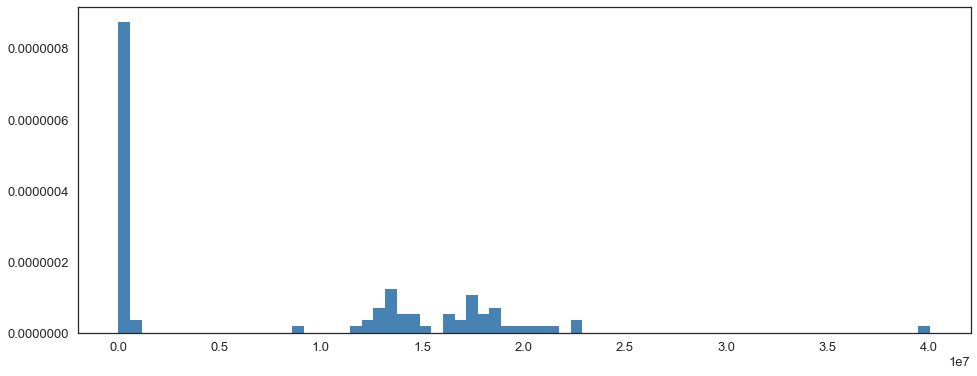

In [278]:
figsize(16, 6)

_hist1 = plt.hist(trap_volume_trace[:,2], bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [16]:
@pymc.deterministic
def model_unc_all(value=0, z_unc_over = z_unc_over, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_res_bot = z_unc_res_bot, fault_sealing=fault_sealing):
    
    new_z_over = over_z + z_unc_over
    new_z_sec_res = sec_res_z + z_unc_seal_top
    new_z_res_top = seal_z + z_unc_res_top
    new_z_res = res_z + z_unc_res_bot
    
    print('Z-Variations:', z_unc_over, z_unc_seal_top, z_unc_res_top, z_unc_res_bot)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Overlying'] = new_z_over
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'] = new_z_sec_res
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z_res_top
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z_res
   
    lith_sol, fault_sol = gp.compute_model(interp_data, get_potential_at_interfaces=False)
    lith_block = lith_sol[0,0]
    fault_block = fault_sol[0,0]  
    seal_surf, seal_surf_simp = gp.get_surfaces(
                                          interp_data = interp_data, potential_lith=lith_sol[0,1], 
        potential_fault=fault_sol[0,1], n_formation = 3)# (interp_data.get_formation_number()['Seal']))
    
    max_vol, lith_sol[0,0], bottom, trap = max_trap_vol(lith_block, fault_block, seal_surf, fault_sealing)
    
    print("Maximum reservoir volume: %s m³" % max_vol)
    #gp.plot_section(geo_data, lith_sol[0,0], 25, plot_data =1)
    
    #gp.plot_section(geo_data, sol[0, 0,:], 23
    #                , plot_data=1, direction='x')
  
    #gp.plot_surfaces_3D(geo_data, [res_surf], 
    #                [res_surf_simp], 
    #                ['Reservoir'], [3])
    return lith_sol, fault_sol, max_vol

Z-Variations: -0.014634934554773804 -0.008319627695623917 -0.022637713268567127 0.009265978923000174
Spill point defines trap.
Fault is pathway. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 12032000.0 m³


In [17]:
iterations = 1000
model2 = pymc.Model([model_unc_all, z_unc_over, z_unc_seal_top, z_unc_res_top, z_unc_res_bot, fault_sealing])

In [18]:
M2 = pymc.MCMC(model2)
M2.sample(iter=iterations)

Z-Variations: 0.01105366690643032 -0.015867503741207274 -0.012325981637274726 0.0026257405875959555
Spill point defines trap.
Fault is pathway. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 11904000.0 m³
 [                  0%                  ] 2 of 1000 complete in 2.4 secZ-Variations: -0.010609089476966427 -0.016554487263445085 -0.017666728950018206 0.055779257723413946


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0466286504140498e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 26
Checking Section: 28
TRAP FOUND, section: 28
Checking Section: 30
TRAP FOUND, section: 30
Checking Section: 31
TRAP FOUND, section: 31
Checking Section: 32
Checking Section: 33
TRAP FOUND, section: 33
Checking Section: 35
TRAP FOUND, section: 35
Maximum reservoir volume: 3968000.0 m³
 [                  0%                  ] 3 of 1000 complete in 4.8 secZ-Variations: 0.012113190238236626 0.032247466023140305 0.003577004350557779 0.05032345262969812
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 18
Checking Section: 20
TRAP FOUND, section: 20
Checking Section: 22
Maximum reservoir volume: 16512000.0 m³
 [                  0%                  ] 4 of 1000 complete in 7.3 secZ-Variations: -0.008612667935828012 0.0008158058066449128 -0.04001711764715881 0.002427007174504998
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUN

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.772029521011746e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 88
TRAP FOUND, section: 88
Checking Section: 89
TRAP FOUND, section: 89
Checking Section: 91
TRAP FOUND, section: 91
Checking Section: 92
TRAP FOUND, section: 92
Checking Section: 93
TRAP FOUND, section: 93
Checking Section: 94
TRAP FOUND, section: 94
Checking Section: 95
TRAP FOUND, section: 95
Checking Section: 96
TRAP FOUND, section: 96
Checking Section: 97
TRAP FOUND, section: 97
Checking Section: 98
TRAP FOUND, section: 98
Checking Section: 99
TRAP FOUND, section: 99
Checking Section: 100
TRAP FOUND, section: 100
Checking Section: 101
TRAP FOUND, section: 101
Checking Section: 102
TRAP FOUND, section: 102
Checking Section: 106
TRAP FOUND, section: 106
Checking Section: 107
TRAP FOUND, section: 107
Checking Section: 108
TRAP FOUND, section: 108
Checking Section: 116
TRAP FOUND, section: 116
Checking Section: 117
TRAP FOUND, section: 117
Checking Section: 124
TRAP FOUND, section: 124
Checking Section: 125
T

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.4744215443870416e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 19
Maximum reservoir volume: 6272000.0 m³
 [                  1%                  ] 15 of 1000 complete in 34.8 secZ-Variations: 0.01234094983395597 0.005440480020265598 0.023091505773697524 0.009261710224877751
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [                  1%                  ] 16 of 1000 complete in 37.4 secZ-Variations: -0.009715689805507334 -0.054476248756013285 -0.032344455448931754 0.006445405164571549
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 13696000.0 m³
 [                  1%                  ] 17 of 1000 complete in 39.9 secZ-Variations: -0.006512862326656145 -0.036336413

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.869960897238343e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 20
TRAP FOUND, section: 20
Maximum reservoir volume: 256000.0 m³
 [                  2%                  ] 21 of 1000 complete in 49.3 secZ-Variations: 0.0017451204973196585 0.013949442380934434 0.00800444414768082 -0.02380856999003768
Spill point defines trap.
Fault is sealing. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [                  2%                  ] 22 of 1000 complete in 51.7 secZ-Variations: -0.0008134310839019818 0.03267278568215582 -0.02347066474832203 0.03566367185547131
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [                  2%                  ] 23 of 1000 complete in 54.1 secZ-Variations: 0.0257726653784776 0.007234604077858607 -0.043942350663599986 -0.0007522310650939914
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [                  2%                  ] 24 of 1000 complete in 56.5 secZ-Variations: -0.03276138555366515 0.018713905329828733 -0.034094472235208055 0.057175675546488405
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 21
TRAP FOUND, section: 21
Maximum reservoir volume: 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.9559724112893093e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 66
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 2%                  ] 27 of 1000 complete in 64.2 secZ-Variations: -0.009229310385280388 0.0023745815584516297 -0.057791899892093136 -0.005075778756491275
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 2%                  ] 28 of 1000 complete in 67.9 secZ-Variations: -0.001110176641694825 -0.00283771383642225 0.02213041796200052 -0.037235773398205115
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Checking Section: 15
TRAP FOUND, section: 15
Maximum reservoir volume: 3520000.0 m³
 [-                 2%                  ] 29 of 1000 complete in 70.6 secZ-Variations: 0.0076975975955550415 -0.014995772261515156 0.0189098462144190

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.544906673231708e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 68
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 3%                  ] 32 of 1000 complete in 78.2 secZ-Variations: -0.02454947356821662 -0.01453389245600072 0.005714088128650333 -0.02975623827448679
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 20096000.0 m³
 [-                 3%                  ] 33 of 1000 complete in 80.6 secZ-Variations: -0.007078380448785844 0.015964691302833955 -0.018627121116276818 -0.03489656075954519


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.983706887642711e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 124
Checking Section: 127
Checking Section: 131
TRAP FOUND, section: 131
Checking Section: 196
TRAP FOUND, section: 196
Maximum reservoir volume: 16192000.0 m³
 [-                 3%                  ] 34 of 1000 complete in 83.2 secZ-Variations: -0.0013855247441889819 0.022427894421684125 0.0075150284570735726 0.0235998168287738


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0412085416078298e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 123
Checking Section: 138
TRAP FOUND, section: 138
Maximum reservoir volume: 64000.0 m³
 [-                 3%                  ] 35 of 1000 complete in 85.8 secZ-Variations: -0.0027797337700721987 -0.0047760188540464255 0.002349047139932289 -0.008339432299103331
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 3%                  ] 36 of 1000 complete in 88.2 secZ-Variations: -0.012020605003676372 -0.005821517992392741 0.01813945348145039 -0.05585347953593503
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 19840000.0 m³
 [-                 3%                  ] 37 of 1000 complete in 91.2 secZ-Variations: -0.0009899146305150388 -0.04121752154573086 -0.048807540688662734 -0.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.041996000594736e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Maximum reservoir volume: 0 m³
 [-                 4%                  ] 42 of 1000 complete in 103.7 secZ-Variations: -0.0004675317938761971 0.015403088867024366 0.008847772992542382 0.011525382096107399
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 4%                  ] 43 of 1000 complete in 106.1 secZ-Variations: 0.0028895733440572756 -0.03491787039861841 -0.01667115798602366 0.01044022635307785
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 18432000.0 m³
 [-                 4%                  ] 44 of 1000 complete in 108.5 secZ-Variations: 0.0014925440831057893 0.0017376817815249865 0.004251846105171094 0.003917227015897168
Spill point defines trap.
Fault is sealing. Down to spill.
Ch

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.4268111076253263e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Maximum reservoir volume: 0 m³
 [-                 4%                  ] 47 of 1000 complete in 116.3 secZ-Variations: 0.0045917338492913245 -0.0038724854866671746 0.0321788494580156 0.05998821600364979
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 4%                  ] 48 of 1000 complete in 119.0 secZ-Variations: -0.006735733393374489 -0.012256128608383418 0.012677023778486908 0.010082380525316872
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 64000.0 m³
 [-                 4%                  ] 49 of 1000 complete in 121.3 secZ-Variations: 0.0017428001209465133 -0.000587816511777501 -0.0022183482397537583 -0.017999188162637632
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 9
TRA

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6921620771270796e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 63
Checking Section: 67
TRAP FOUND, section: 67
Checking Section: 69
Maximum reservoir volume: 1920000.0 m³
 [--                5%                  ] 55 of 1000 complete in 136.8 secZ-Variations: 0.019458311846243883 0.04976914823128164 -0.027787619363356986 0.0466020676026807


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.769644400606012e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 62
Checking Section: 63
TRAP FOUND, section: 63
Checking Section: 65
TRAP FOUND, section: 65
Checking Section: 68
TRAP FOUND, section: 68
Checking Section: 69
TRAP FOUND, section: 69
Checking Section: 71
Checking Section: 72
TRAP FOUND, section: 72
Checking Section: 73
TRAP FOUND, section: 73
Checking Section: 74
TRAP FOUND, section: 74
Checking Section: 76
TRAP FOUND, section: 76
Checking Section: 77
TRAP FOUND, section: 77
Checking Section: 78
TRAP FOUND, section: 78
Checking Section: 79
TRAP FOUND, section: 79
Checking Section: 81
TRAP FOUND, section: 81
Checking Section: 82
TRAP FOUND, section: 82
Checking Section: 85
TRAP FOUND, section: 85
Checking Section: 86
TRAP FOUND, section: 86
Checking Section: 93
TRAP FOUND, section: 93
Checking Section: 101
TRAP FOUND, section: 101
Checking Section: 102
TRAP FOUND, section: 102
Checking Section: 108
TRAP FOUND, section: 108
Checking Section: 109
TRAP FOUND, sect

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0479472400959366e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 120
Checking Section: 122
TRAP FOUND, section: 122
Checking Section: 123
Maximum reservoir volume: 17152000.0 m³
 [--                6%                  ] 69 of 1000 complete in 171.2 secZ-Variations: 0.008896657166912944 0.008967415260637386 0.013238511633234229 0.01027593265082864
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--                7%                  ] 70 of 1000 complete in 173.8 secZ-Variations: -0.005011594272083607 -0.0008147473134567348 0.04229893362816762 0.033114088754769226
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 21
TRAP FOUND, section: 21
Maximum reservoir volume: 64000.0 m³
 [--                7%                  ] 71 of 1000 complete in 176.5 secZ-Variations: -0.007387617971348644 0.009433532544373653 0.015884

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4155386196534891e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 125
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--                7%                  ] 74 of 1000 complete in 184.4 secZ-Variations: 0.02406164323704858 0.03083345504891547 0.007579627395138539 0.008872885041193471
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--                7%                  ] 75 of 1000 complete in 186.8 secZ-Variations: -0.0050605314470334 0.013237225515505277 0.015639954886345803 0.00560911913458833
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 56960000.0 m³
 [--                7%                  ] 76 of 1000 complete in 189.6 secZ-Variations: -0.000573794422134994 -0.002458703460965247 -0.005963861395535747 0.00440065336527552
Spill point defines tra

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.2848795683548815e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 5248000.0 m³
 [---               8%                  ] 88 of 1000 complete in 220.2 secZ-Variations: -0.004368372125970365 -0.021369215467007888 -0.0014830550724053415 0.006867645553032181
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---               8%                  ] 89 of 1000 complete in 222.6 secZ-Variations: 0.009563517953848506 0.018622463926375944 -0.03152990982349628 -0.019117108212475878
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 15
TRAP FOUND, section: 15
Checking Section: 16
Checking Section: 20
TRAP FOUND, section: 20
Maximum reservoir volume: 14528000.0 m³
 [---               9%                  ] 90 of 1000 complete in 225.0 secZ-Variations: 0.00875907677442

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.239641443997243e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 24
TRAP FOUND, section: 24
Maximum reservoir volume: 64000.0 m³
 [---              10%                  ] 104 of 1000 complete in 260.2 secZ-Variations: -0.009111513872344748 0.0017460242405895395 -0.00021049276700637397 -0.026565189749922676
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---              10%                  ] 105 of 1000 complete in 262.6 secZ-Variations: -0.0015917133610520566 0.0061194369718823695 0.020821097545948623 0.033353917529437206
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 19
Maximum reservoir volume: 70400000.0 m³
 [----             10%                  ] 106 of 1000 complete in 265.3 secZ-Variations: 0.018025334742318874 0.029453729822418336 0.0021108838724184877

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0074191258979681e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 130
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----             11%                  ] 112 of 1000 complete in 280.1 secZ-Variations: 0.017283913385199065 -0.007795286180716579 -0.018851308431783693 0.010507940555524693
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 15872000.0 m³
 [----             11%                  ] 113 of 1000 complete in 282.5 secZ-Variations: 0.0003769457863859227 -0.016730931949175853 0.030030945224704394 0.011596080037210637
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 3456000.0 m³
 [----             11%                  ] 114 of 1000 complete in 285.1 secZ-Variations: -0.010798645558877773 0.02007756117987387 0.00690084532034

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.478776543554886e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----             11%                  ] 115 of 1000 complete in 287.5 secZ-Variations: -0.011002075283629904 -0.006216471124715779 0.01993838451684661 -0.022959835467310997
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 17
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 22016000.0 m³
 [----             11%                  ] 116 of 1000 complete in 290.4 secZ-Variations: -0.008056154143278581 -0.0007790197200536318 -0.03322631822325143 -0.04833570473993788
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----             11%                  ] 117 of 1000 complete in 292.8 secZ-Variations: 0.008723219108326397 0.01004700849948609 -0.015113014836862266 0.013541242818685167
Spill point de

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.564513932438842e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 67
Checking Section: 70
Checking Section: 72
TRAP FOUND, section: 72
Maximum reservoir volume: 17664000.0 m³
 [----             12%                  ] 125 of 1000 complete in 313.2 secZ-Variations: 0.010863481296572932 0.011903837355480212 0.01442009630930464 0.007666823590241875
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 56832000.0 m³
 [----             12%                  ] 126 of 1000 complete in 315.8 secZ-Variations: 0.011851548913761507 0.012766861004810554 0.022720599722288005 -0.0164089587674488
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 16
Checking Section: 18
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 29184000.0 m³
 [----             12%                  ] 127 of 1000 complete in 318.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.2765572538219203e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 41
Checking Section: 44
TRAP FOUND, section: 44
Checking Section: 46
Checking Section: 77
TRAP FOUND, section: 77
Maximum reservoir volume: 38080000.0 m³
 [----             13%                  ] 131 of 1000 complete in 328.8 secZ-Variations: -0.007320396790222984 0.003856997364378307 0.014744195699780499 -0.05301298947190396
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 33920000.0 m³
 [-----            13%                  ] 132 of 1000 complete in 331.8 secZ-Variations: 0.006459489141734713 -0.013745911612640748 0.015353242485226752 0.01755498103446407
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 19
Maximum reservoir volume: 55552000.0 m³
 [----- 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.425823618703362e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 21
Checking Section: 23
Checking Section: 25
TRAP FOUND, section: 25
Maximum reservoir volume: 22400000.0 m³
 [-----            13%                  ] 138 of 1000 complete in 347.3 secZ-Variations: -0.01476382847848546 -0.014338449141556013 -0.009241514905320025 0.0072457938164980275
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----            13%                  ] 139 of 1000 complete in 349.8 secZ-Variations: -0.006354017554895713 0.00793728384966425 -0.011010363290411891 0.009531378919566801
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----            14%                  ] 140 of 1000 complete in 352.2 secZ-Variations: 0.010740310373572896 -0.03720916215362239 0.0011149764096264171 0.0043661518130856955
Spill point d

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.7969234039915136e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 18
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           16%                  ] 160 of 1000 complete in 401.2 secZ-Variations: -0.0022048670754137075 0.02504203174143872 -0.03445247624131999 -0.05697263619955321


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.6387471641651246e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 126
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           16%                  ] 161 of 1000 complete in 403.8 secZ-Variations: -0.0032243183137177817 0.03821366529617518 0.0009078257115550622 0.04813534542993031
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           16%                  ] 162 of 1000 complete in 406.2 secZ-Variations: 0.00808703146136926 -0.00903840508928363 0.011099156654674217 0.007541373891506913
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           16%                  ] 163 of 1000 complete in 408.6 secZ-Variations: -0.016997930963953863 -0.005159733010977822 0.015591524635886098 0.013650107318665913
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Sec

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.5901997819109965e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 71
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           16%                  ] 168 of 1000 complete in 422.3 secZ-Variations: -0.0066364400851951855 -0.010156418101984262 -0.04589079212654186 -0.005259620198733765
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           16%                  ] 169 of 1000 complete in 424.7 secZ-Variations: 0.005319265722695798 0.01883088884760933 -0.025909013032764164 0.008501037619571241
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 20
TRAP FOUND, section: 20
Maximum reservoir volume: 64000.0 m³
 [------           17%                  ] 170 of 1000 complete in 427.2 secZ-Variations: -0.025975250376358915 -0.018499266355362278 -0.004606920511567686 -0.01108075428212944
Spill point defines trap.
Fault is sealing. Down t

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4830948968924673e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 75
Checking Section: 77
TRAP FOUND, section: 77
Checking Section: 78
Maximum reservoir volume: 21376000.0 m³
 [------           17%                  ] 174 of 1000 complete in 437.1 secZ-Variations: 0.004312372593417582 0.010109343518871713 0.022936661511386333 0.0415245745303007
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 7
TRAP FOUND, section: 7
Checking Section: 11
Checking Section: 12
Maximum reservoir volume: 64000.0 m³
 [------           17%                  ] 175 of 1000 complete in 439.7 secZ-Variations: 0.0018149026222654785 0.000536004519940785 0.001006675149549658 0.004624607806828498
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           17%                  ] 176 of 1000 complete in 442.2 secZ-Variations: 0.0063270303803519895 -0.00444707184410958 0.00306983832

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4959251615209723e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 23
Checking Section: 25
TRAP FOUND, section: 25
Checking Section: 27
Checking Section: 29
TRAP FOUND, section: 29
Maximum reservoir volume: 4608000.0 m³
 [------           18%                  ] 180 of 1000 complete in 451.7 secZ-Variations: -0.006370731483808677 -0.02269345894701861 0.024161136202216337 -0.002313582951124546
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Maximum reservoir volume: 4096000.0 m³
 [------           18%                  ] 181 of 1000 complete in 454.6 secZ-Variations: -0.019707206453497834 0.03024307475695511 -0.01048851912047035 0.05780492736507993
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------           18%                  ] 182 of 1000 complete in 457.0 secZ-Variations: 0.0007

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.313080026463467e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 54
Checking Section: 56
Checking Section: 59
TRAP FOUND, section: 59
Maximum reservoir volume: 21376000.0 m³
 [-------          19%                  ] 193 of 1000 complete in 485.4 secZ-Variations: 0.005371427549688278 -0.0002310664223807769 -0.011354650768613334 -0.021016841792630407
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------          19%                  ] 194 of 1000 complete in 487.8 secZ-Variations: -0.00197848081827468 -0.011776737071855416 0.02660025926465147 0.004103385428304857
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------          19%                  ] 195 of 1000 complete in 490.4 secZ-Variations: 0.0001295783626939701 0.00814251958056492 -0.018877777849218822 0.0018142960447847844
Spill point defines trap.
F

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.003097992504422e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 115
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------          20%                  ] 206 of 1000 complete in 517.4 secZ-Variations: -0.01581777603722863 -0.00791006740638456 0.004884940971282741 0.05074384181200289
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 19
Maximum reservoir volume: 18432000.0 m³
 [-------          20%                  ] 207 of 1000 complete in 519.8 secZ-Variations: -0.018134721986429375 0.0033778334410416414 0.00809494403174774 -0.005877349480053557


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.36679749529867e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 29
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------          20%                  ] 208 of 1000 complete in 522.3 secZ-Variations: 0.00914475165796527 -0.004088252808246738 0.007862588262180541 0.03103459749403756
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------          20%                  ] 209 of 1000 complete in 524.6 secZ-Variations: 0.015229914045550139 0.009599084486668316 -0.00041255256850276337 0.014437626602066194
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------          21%                  ] 210 of 1000 complete in 527.0 secZ-Variations: 0.00923704134085254 -0.0009020414105491945 0.011667663722859812 -0.006082387851211403
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No t

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1329611410436655e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 115
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------         21%                  ] 213 of 1000 complete in 534.7 secZ-Variations: -0.0071476812543668205 -0.010244046422209076 -0.003598902358953005 0.008787570539814759
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 21632000.0 m³
 [--------         21%                  ] 214 of 1000 complete in 537.1 secZ-Variations: 0.015201751078735637 0.02154599299379691 -0.018680590714295044 0.018931744819248524
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 22
TRAP FOUND, section: 22
Maximum reservoir volume: 15808000.0 m³
 [--------         21%                  ] 215 of 1000 complete in 539.5 secZ-Variations: -0.002900959

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2744250099672172e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 57
Checking Section: 61
TRAP FOUND, section: 61
Checking Section: 62
Maximum reservoir volume: 36928000.0 m³
 [--------         21%                  ] 216 of 1000 complete in 543.0 secZ-Variations: -0.001199449301025671 -0.014441877565145696 -0.0007489984049532524 -0.028391524715143248
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------         21%                  ] 217 of 1000 complete in 545.4 secZ-Variations: -0.003307350305948824 -0.02108255226348649 -0.006685133976399512 -0.0192330345288206
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 18112000.0 m³
 [--------         21%                  ] 218 of 1000 complete in 547.8 secZ-Variations: -0.0070834188583090854 0.01433897067719463

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.7371147126586948e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 59
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------         22%                  ] 226 of 1000 complete in 569.6 secZ-Variations: -0.0037329951836211936 -0.026515407628074684 0.013220704740515073 0.0041729423561529385
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Maximum reservoir volume: 3584000.0 m³
 [--------         22%                  ] 227 of 1000 complete in 572.3 secZ-Variations: 0.004884769177563126 -0.0010235016963911394 -0.016272697859153442 0.009864653848861907
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 18688000.0 m³
 [--------         22%                  ] 228 of 1000 complete in 574.8 secZ-Variations: 0.004500898915182596 0.017677724417290305 -0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.6559384025404142e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------         22%                  ] 229 of 1000 complete in 577.2 secZ-Variations: 0.0030392470867965904 0.02570160866709846 1.4851353871242196e-06 -0.012384655462768852


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.4614818627810564e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 111
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------         23%                  ] 230 of 1000 complete in 579.8 secZ-Variations: 0.010294486447615145 0.00639012692070563 0.024506492556611595 0.036509181515586055
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 15
Checking Section: 17
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 28544000.0 m³
 [--------         23%                  ] 231 of 1000 complete in 582.4 secZ-Variations: -0.008940784265031382 -0.007545429027146552 -0.004554759198996695 0.0035600829307891675
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Checking Section: 21
TRAP FOUND, section: 21
Maximum reservoir volume: 20672000.0 m³
 [--------         23%                  ] 232 of 1000 complete in 584.9 secZ-Variations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.84901161048856e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 99
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------        24%                  ] 243 of 1000 complete in 612.9 secZ-Variations: -0.0008491987730945695 0.015936261400378713 -0.00784025609557668 -0.03262006969489158
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------        24%                  ] 244 of 1000 complete in 615.3 secZ-Variations: -0.018133650808737318 -0.0034633381335168406 -0.03546262444466055 -0.025456453720075354
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------        24%                  ] 245 of 1000 complete in 617.9 secZ-Variations: 0.015668475064193724 0.007995877567128195 0.009371917717870217 -0.02505855293748718
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No

 [----------       26%                  ] 267 of 1000 complete in 671.9 secZ-Variations: -0.0013261229967527735 0.036410768360955435 -0.012068821809398781 -0.03989453750321453
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----------       26%                  ] 268 of 1000 complete in 674.3 secZ-Variations: -0.0014180660146881716 -0.012981887250963801 0.04521936878551238 0.013687785121576725
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
Checking Section: 19
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----------       26%                  ] 269 of 1000 complete in 677.0 secZ-Variations: 0.0007062015525166285 0.02529667630763496 -0.004113553451159051 -0.006820983652947467


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.877205082136186e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 53
Checking Section: 56
TRAP FOUND, section: 56
Checking Section: 60
Maximum reservoir volume: 21184000.0 m³
 [----------       27%                  ] 270 of 1000 complete in 679.6 secZ-Variations: 0.006001922409190451 0.033329716766730494 -0.026789708127436404 0.002791774504357914


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.1723237370329116e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 119
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----------       27%                  ] 271 of 1000 complete in 682.2 secZ-Variations: -0.0006040308428155809 0.01050356099561061 -0.006522308012437347 -0.01172310041206476
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 18176000.0 m³
 [----------       27%                  ] 272 of 1000 complete in 684.6 secZ-Variations: -0.008047340560641573 -0.0005547655731680301 -0.030612800977388055 0.06602145231692874
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----------       27%                  ] 273 of 1000 complete in 687.0 secZ-Variations: -0.009226668224648946 -0.010262887659002367 0.007475105756837535 0.017917087354647757
Spill point defines trap.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.326725371901375e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
Checking Section: 19
TRAP FOUND, section: 19
Checking Section: 20
Maximum reservoir volume: 20864000.0 m³
 [----------       28%                  ] 283 of 1000 complete in 711.5 secZ-Variations: -0.0013581209953874374 0.004818073593775953 -0.009927879117659463 -0.01587879911367621
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----------       28%                  ] 284 of 1000 complete in 713.9 secZ-Variations: -0.00200113105247695 -0.02542355272187938 0.03750110650569137 0.005494602890726502
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 9
TRAP FOUND, section: 9
Checking Section: 19
Checking Section: 21
TRAP FOUND, section: 21
Checking Section: 22
Maximum reservoir volume: 1472000.0 m³
 [----------       28%                  ] 285 of 1000 complete in 716.5 secZ-Variations: -0.008325156258716

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.3133077798639405e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 90
TRAP FOUND, section: 90
Checking Section: 91
TRAP FOUND, section: 91
Checking Section: 92
TRAP FOUND, section: 92
Checking Section: 97
TRAP FOUND, section: 97
Checking Section: 98
TRAP FOUND, section: 98
Checking Section: 101
TRAP FOUND, section: 101
Checking Section: 102
TRAP FOUND, section: 102
Checking Section: 103
TRAP FOUND, section: 103
Checking Section: 116
Checking Section: 118
TRAP FOUND, section: 118
Checking Section: 138
TRAP FOUND, section: 138
Checking Section: 146
Checking Section: 152
TRAP FOUND, section: 152
Checking Section: 157
TRAP FOUND, section: 157
Checking Section: 158
TRAP FOUND, section: 158
Checking Section: 176
TRAP FOUND, section: 176
Checking Section: 177
TRAP FOUND, section: 177
Checking Section: 181
Checking Section: 183
Maximum reservoir volume: 1280000.0 m³
 [-----------      29%                  ] 299 of 1000 complete in 752.0 secZ-Variations: 0.0021162443410318

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.064781057242726e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 55
Checking Section: 58
TRAP FOUND, section: 58
Checking Section: 62
Maximum reservoir volume: 33472000.0 m³
 [------------     31%                  ] 318 of 1000 complete in 800.7 secZ-Variations: -0.0006941464206641134 0.01666118066620111 -0.03099870281937293 0.010588847017189177
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 14976000.0 m³
 [------------     31%                  ] 319 of 1000 complete in 803.1 secZ-Variations: 0.0003918307641526422 0.013460550152952274 0.03705968570750181 0.040316366424680235
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------------     32%                  ] 320 of 1000 complete in 805.7 secZ-Variations: -2.2161503366585254e-05 -0.020600367835837158 0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0672326073167824e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 88
Checking Section: 178
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------------     32%                  ] 323 of 1000 complete in 814.9 secZ-Variations: 0.015938357328808623 -0.017694059104136302 0.003066361027191863 -0.013352511088329532
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 16384000.0 m³
 [------------     32%                  ] 324 of 1000 complete in 817.2 secZ-Variations: 0.014436404207231322 0.03394931935903392 -0.035645714737384024 -0.008121624361056755
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------------     32%                  ] 325 of 1000 complete in 819.7 secZ-Variations: -0.006203781595123331 0.0007993477545675884 -0.037784300333964696 -0.002435880

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.611155629026143e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 18
Checking Section: 22
TRAP FOUND, section: 22
Checking Section: 27
Maximum reservoir volume: 256000.0 m³
 [------------     34%                  ] 340 of 1000 complete in 857.4 secZ-Variations: -0.008953707773287151 -0.003027335506794212 0.0021398015171020615 0.04658810417100982
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [------------     34%                  ] 341 of 1000 complete in 859.8 secZ-Variations: 0.0021673531463426298 0.006350309586020475 0.012921765527053016 -0.0012402104830717875
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 51712000.0 m³
 [------------     34%                  ] 342 of 1000 complete in 862.5 secZ-Variations: 0.00074163993733056 -0.008311070502602614 -0.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8313307537098922e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 93
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------------    34%                  ] 347 of 1000 complete in 874.8 secZ-Variations: -0.006488581962855022 -0.003974153079338371 0.01103372008525783 -0.006482369888290256
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------------    34%                  ] 348 of 1000 complete in 877.3 secZ-Variations: 0.007374108149173198 0.007314308986427826 -0.018829386632289884 0.04976376323560751


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.954870729851791e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 20
TRAP FOUND, section: 20
Maximum reservoir volume: 7936000.0 m³
 [-------------    34%                  ] 349 of 1000 complete in 879.7 secZ-Variations: -0.0043431010878689676 0.010833556424550668 -0.01389998509368455 -0.009327085235003018
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 22272000.0 m³
 [-------------    35%                  ] 350 of 1000 complete in 882.1 secZ-Variations: -0.0020977715474478523 0.004117894374822985 0.002005965069446897 -0.047569314283537834
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------------    35%                  ] 351 of 1000 complete in 884.5 secZ-Variations: 0.007365863196920498 -0.035409673601313155 0.008389054207

Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------------   37%                  ] 373 of 1000 complete in 941.3 secZ-Variations: -0.014321594132695235 0.0031985899735843906 0.030826778548836836 0.026013446697781384
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 19
Checking Section: 23
TRAP FOUND, section: 23
Maximum reservoir volume: 3776000.0 m³
 [--------------   37%                  ] 374 of 1000 complete in 944.0 secZ-Variations: 0.006030528207882388 -0.01935454029273995 -0.00690920116578906 -0.02164851074140051
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17536000.0 m³
 [--------------   37%                  ] 375 of 1000 complete in 946.4 secZ-Variations: -0.0017461261271

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.0491559499523646e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 81
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------------   38%                  ] 381 of 1000 complete in 961.3 secZ-Variations: -0.00014669734811015653 0.018242808120367885 -0.02062125775022683 0.021581147115636173
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 13824000.0 m³
 [--------------   38%                  ] 382 of 1000 complete in 963.7 secZ-Variations: -0.0009148108725060827 -0.015830951353262214 0.021174173865160777 -0.054585096056017364
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Maximum reservoir volume: 2688000.0 m³
 [--------------   38%                  ] 383 of 1000 complete in 966.3 secZ-Variations: -0.012209977389069065 0.00994949817284997 -0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.751375388105771e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 77
Checking Section: 82
Checking Section: 84
TRAP FOUND, section: 84
Maximum reservoir volume: 12032000.0 m³
 [--------------   38%                  ] 384 of 1000 complete in 968.9 secZ-Variations: -0.006555032070003769 -0.019507054584113493 -0.012011101477041122 0.02481157548092333
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------------   38%                  ] 385 of 1000 complete in 971.2 secZ-Variations: 0.003740263278346911 0.020412606070965855 -0.012875012559043462 -0.012200739376649618
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 13
Checking Section: 15
TRAP FOUND, section: 15
Checking Section: 16
Maximum reservoir volume: 11264000.0 m³
 [--------------   38%                  ] 386 of 1000 complete in 973.6 secZ-Variations: -0.018536203721580203 -0.005470078269371264 0.002371550045

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.784432819515132e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 115
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------  40%                  ] 401 of 1000 complete in 1009.3 secZ-Variations: 0.001909528694745341 0.012503776889099656 0.024146746706655373 0.01806108773078021
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 12
Checking Section: 13
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------  40%                  ] 402 of 1000 complete in 1012.0 secZ-Variations: 0.0006824548500826411 -0.007453756812174039 0.045942189933436434 -0.03057251909014527
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------  40%                  ] 403 of 1000 complete in 1014.7 secZ-Variations: -0.008006973902523815 -0.01057364348129782 0.00025270825144239667 -0.04708866376752192
Spill point defines trap.
Fault is pathway. Dow

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.158306682848888e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 9
TRAP FOUND, section: 9
Checking Section: 13
TRAP FOUND, section: 13
Checking Section: 18
Checking Section: 20
TRAP FOUND, section: 20
Checking Section: 22
Maximum reservoir volume: 6528000.0 m³
 [---------------  41%                  ] 419 of 1000 complete in 1053.3 secZ-Variations: -0.009565467889554312 0.010801091539785453 -0.026260392550003626 -0.011416801080726091
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------  42%                  ] 420 of 1000 complete in 1055.7 secZ-Variations: 0.0014503150684652165 -0.00017192618398421733 -0.022254911153270242 -0.0072110124120960874
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 12032000.0 m³
 [---------------  42%                  ] 421 of 100

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.966993844528588e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 44
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------- 42%                  ] 422 of 1000 complete in 1060.5 secZ-Variations: -0.00765333691242245 0.008853103008855903 -0.00288256506936913 -0.0006559767701959496
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 22656000.0 m³
 [---------------- 42%                  ] 423 of 1000 complete in 1062.9 secZ-Variations: 0.005684783055382743 0.001998898107513416 -0.010019127124662955 -0.005893436541783695
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 64000.0 m³
 [---------------- 42%                  ] 424 of 1000 complete in 1065.3 secZ-Variations: 0.008840259689005415 -0.038621205203607414 0.04134405607960671 0.00538056217209

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.519908275961825e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 35
Checking Section: 39
TRAP FOUND, section: 39
Checking Section: 40
Maximum reservoir volume: 4480000.0 m³
 [---------------- 43%                  ] 434 of 1000 complete in 1089.8 secZ-Variations: 0.00660508611785549 -0.007711761741150245 0.014712680784773993 -0.004064985687832962
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 31488000.0 m³
 [---------------- 43%                  ] 435 of 1000 complete in 1092.5 secZ-Variations: 0.0027635101947955233 -0.025211964003479567 0.00791884456362764 -0.058211655241732836
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------- 43%                  ] 436 of 1000 complete in 1094.8 secZ-Variations: -0.01100946538199596 -0.008383488950351086 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.9641960825065325e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 53
Checking Section: 55
TRAP FOUND, section: 55
Checking Section: 58
Maximum reservoir volume: 19072000.0 m³
 [---------------- 44%                  ] 444 of 1000 complete in 1114.2 secZ-Variations: -0.01522507509153988 -0.019534053768290056 0.012274863031747584 0.010028869162814797
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------- 44%                  ] 445 of 1000 complete in 1116.5 secZ-Variations: -0.00984019175294066 0.028085789199905942 0.013642945655174016 -0.026111788692512634
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 54400000.0 m³
 [---------------- 44%                  ] 446 of 1000 complete in 1119.3 secZ-Variations: 0.0016750010467751514 -0.011327493118637857

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.651078740394496e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 20
Checking Section: 22
TRAP FOUND, section: 22
Checking Section: 23
TRAP FOUND, section: 23
Checking Section: 24
TRAP FOUND, section: 24
Checking Section: 25
TRAP FOUND, section: 25
Checking Section: 26
TRAP FOUND, section: 26
Maximum reservoir volume: 1664000.0 m³
 [-----------------45%                  ] 458 of 1000 complete in 1150.5 secZ-Variations: 0.0033993580607244865 0.024470371652073553 0.0021663322369287487 -0.0032164220123425207


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.3148117018508856e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 19
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------45%                  ] 459 of 1000 complete in 1152.9 secZ-Variations: -0.014015284654692794 0.0044535382861822575 -0.015296330835496382 -0.07248873311905027
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 20864000.0 m³
 [-----------------46%                  ] 460 of 1000 complete in 1155.4 secZ-Variations: 0.009546474830930523 -0.018367796391131445 -0.023026615851253766 0.03931000551283289
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 22
Maximum reservoir volume: 9344000.0 m³
 [-----------------46%                  ] 461 of 1000 complete in 1157.9 secZ-Variations: -0.006119614271065807 -0.0079921966

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.7539595603975897e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 56
TRAP FOUND, section: 56
Checking Section: 57
TRAP FOUND, section: 57
Checking Section: 58
TRAP FOUND, section: 58
Checking Section: 59
TRAP FOUND, section: 59
Checking Section: 61
TRAP FOUND, section: 61
Checking Section: 62
TRAP FOUND, section: 62
Checking Section: 63
TRAP FOUND, section: 63
Checking Section: 67
TRAP FOUND, section: 67
Checking Section: 68
TRAP FOUND, section: 68
Maximum reservoir volume: 704000.0 m³
 [-----------------46%                  ] 463 of 1000 complete in 1163.2 secZ-Variations: -0.007353177762448201 0.030315062090800614 -0.03496509078356057 0.0014672294584247977
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------46%                  ] 464 of 1000 complete in 1165.7 secZ-Variations: -0.019159500724187484 -0.023587778548446327 0.015888436660449166 0.051148705724990175
Fault leak poin

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.820169235448702e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 23
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------46%                  ] 469 of 1000 complete in 1178.5 secZ-Variations: -0.01855909687329649 -0.004755982157736237 -0.017771890788150505 -0.012284653865308368
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 17280000.0 m³
 [-----------------47%                  ] 470 of 1000 complete in 1180.8 secZ-Variations: 0.0060907086509846865 -0.011393093371717827 0.010765457820803357 0.025842501613436826
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------47%                  ] 471 of 1000 complete in 1183.2 secZ-Variations: 0.002316547061041566 -0.007276929950438259 0.03348150848007446 0.003664738992764797
Spill point defines trap.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.439792534669749e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 19
Checking Section: 21
TRAP FOUND, section: 21
Checking Section: 24
Maximum reservoir volume: 17664000.0 m³
 [-----------------47%                  ] 473 of 1000 complete in 1188.3 secZ-Variations: 0.011654692762971453 0.026273066802366234 -0.04640023232444333 0.03457380395022336


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4105446588530413e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 19
Checking Section: 21
TRAP FOUND, section: 21
Maximum reservoir volume: 640000.0 m³
 [-----------------47%                  ] 474 of 1000 complete in 1190.7 secZ-Variations: -0.0025246369247357687 -0.0065969261413317635 0.011044176131443713 0.017808972206667037
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------47%                  ] 475 of 1000 complete in 1193.1 secZ-Variations: 0.014728558361865055 -0.014953984857660056 0.013711006163173438 0.014366949479031037
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Maximum reservoir volume: 0 m³
 [-----------------47%                  ] 476 of 1000 complete in 1195.2 secZ-Variations: 0.004096726326649298 -0.014758218548864574 0.008758201895793762 -0.03903857659708303
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.596362319058244e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------49%                  ] 490 of 1000 complete in 1229.4 secZ-Variations: -0.01283167219115871 0.01064427174291765 0.02294327326124141 -0.023214501575113188


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2384086645056414e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 60
Checking Section: 66
Checking Section: 70
TRAP FOUND, section: 70
Maximum reservoir volume: 27456000.0 m³
 [-----------------49%                  ] 491 of 1000 complete in 1232.6 secZ-Variations: -0.013586535607663621 0.01157812144137779 0.0227862112104394 -0.009542520070589458


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.059247465410976e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 48
Checking Section: 53
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------49%                  ] 492 of 1000 complete in 1235.7 secZ-Variations: -0.012050043728325487 0.02385251304850302 0.00014720140418917024 0.013939120585550751
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------49%                  ] 493 of 1000 complete in 1238.1 secZ-Variations: -0.0029665400043708125 -0.01087055976341242 0.038047762681452685 0.022352213208987726
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 18
Checking Section: 20
TRAP FOUND, section: 20
Checking Section: 21
Maximum reservoir volume: 1920000.0 m³
 [-----------------49%                  ] 494 of 1000 complete in 1240.7 secZ-Variations: -0.012224808256053264 0.0012833817958531394 0.01372572844228484 -0.01531797142

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.508775137106568e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------50%                  ] 504 of 1000 complete in 1264.9 secZ-Variations: -0.007192096418474631 0.024118011063161214 0.050947356395662634 -0.010298846181385256
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------50%                  ] 505 of 1000 complete in 1268.0 secZ-Variations: 0.001759321463300502 -0.006806150299583307 0.022679983774468053 0.002167555456308252
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 16
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 26112000.0 m³
 [-----------------50%                  ] 506 of 1000 complete in 1270.8 secZ-Variations: 0.003393816844048004 0.0052229998459448765 -0.0002688713117850759 -0.02384233605030

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7743333913244896e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 124
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------51%                  ] 511 of 1000 complete in 1285.2 secZ-Variations: 0.0005683881828339376 -0.007438918302421854 0.0038879296682745885 -0.012830053347454578
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17408000.0 m³
 [-----------------51%                  ] 512 of 1000 complete in 1287.5 secZ-Variations: -0.003012535833168202 -0.013181692557947515 0.003912372270700663 0.010234394895904428
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17408000.0 m³
 [-----------------51%                  ] 513 of 1000 complete in 1289.9 secZ-Variations: -0.01221021213634322 -0.004303072664539584 -0.037176

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.575049317168123e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 28
Checking Section: 30
TRAP FOUND, section: 30
Checking Section: 31
Maximum reservoir volume: 20864000.0 m³
 [-----------------53%                  ] 530 of 1000 complete in 1331.6 secZ-Variations: -0.009734795156893397 0.010091173298430782 0.02987774881103921 0.02307045722082697
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------53%                  ] 531 of 1000 complete in 1334.2 secZ-Variations: -0.010840110543547662 0.0483020166665867 0.008370751333385737 -0.039066101903265225
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------53%                  ] 532 of 1000 complete in 1336.6 secZ-Variations: 0.00022987495583068994 0.012860103734668497 -0.021270718825565815 -0.028091477611520053
Spill point defines trap.
F

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.001883814273242e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 109
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------54%                  ] 543 of 1000 complete in 1363.6 secZ-Variations: -0.010489326262549835 0.04009410854498745 0.010711277334432069 -0.01290743639196548
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 9
TRAP FOUND, section: 9
Checking Section: 15
Maximum reservoir volume: 64000.0 m³
 [-----------------54%                  ] 544 of 1000 complete in 1366.0 secZ-Variations: -0.01689639302673341 0.005201366240424493 -0.00889302025498748 0.010017449946074305


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.560073480457504e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 77
Checking Section: 119
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------54%                  ] 545 of 1000 complete in 1368.5 secZ-Variations: 0.017685245315515 -0.002260609803372385 0.03516460430337031 0.01009368317293549
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------54%                  ] 546 of 1000 complete in 1371.0 secZ-Variations: 0.009793157458076752 -0.015385193665540134 0.010614487703290234 0.0032976330108388414
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------54%                  ] 547 of 1000 complete in 1373.3 secZ-Variations: -0.007606428826941607 0.019258371849669453 0.015007681978061474 0.004615920658343741


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.727268520023699e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 58
Checking Section: 61
TRAP FOUND, section: 61
Checking Section: 64
Maximum reservoir volume: 256000.0 m³
 [-----------------54%                  ] 548 of 1000 complete in 1376.2 secZ-Variations: -0.007872513302386752 -0.0242621653753601 0.00941231043809609 0.01641862188699898
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------54%                  ] 549 of 1000 complete in 1378.6 secZ-Variations: 0.007993661050212623 0.014200464986500195 0.020151579878879965 -0.01069604573694496
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Maximum reservoir volume: 2688000.0 m³
 [-----------------55%                  ] 550 of 1000 complete in 1381.3 secZ-Variations: -0.0059829538547789335 -0.00379628079824

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.4473243693564655e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------56%-                 ] 563 of 1000 complete in 1413.7 secZ-Variations: 0.0018245579044881145 -0.00899406264851188 -0.028988539314849723 -0.006067858881348377
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17280000.0 m³
 [-----------------56%-                 ] 564 of 1000 complete in 1416.1 secZ-Variations: 0.007567968308636157 -0.027934559923075072 0.005415567156152641 -0.004769982093701917
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 19840000.0 m³
 [-----------------56%-                 ] 565 of 1000 complete in 1418.4 secZ-Variations: -0.013332457505495424 -0.015966093275843595 0.01335850

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5768302219498764e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 113
Checking Section: 125
TRAP FOUND, section: 125
Maximum reservoir volume: 64000.0 m³
 [-----------------57%-                 ] 573 of 1000 complete in 1438.6 secZ-Variations: 0.013453501165388876 -0.03394577830330735 0.019863410720734897 -0.03029280111055055
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Checking Section: 14
Maximum reservoir volume: 7936000.0 m³
 [-----------------57%-                 ] 574 of 1000 complete in 1441.1 secZ-Variations: 0.024092641988174374 0.015327398150768926 0.03985659413905733 -0.04491571881727238
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Checking Section: 15
TRAP FOUND, section: 15
Maximum reservoir volume: 2240000.0 m³
 [-----------------57%-     

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4068830544999855e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 124
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------57%-                 ] 576 of 1000 complete in 1446.3 secZ-Variations: 0.014022293354519391 0.016274055902561826 -0.003129959403676924 -0.02415584911853836
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 22912000.0 m³
 [-----------------57%-                 ] 577 of 1000 complete in 1448.6 secZ-Variations: -0.00014234725915774843 0.026064688483252118 0.00784576079921205 0.007615001512586317


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.585843230297542e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 60
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------57%-                 ] 578 of 1000 complete in 1451.2 secZ-Variations: 0.0030324508076102555 -0.007999119279505681 0.006520692351877876 0.05198721333733774
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 19
Maximum reservoir volume: 19968000.0 m³
 [-----------------57%--                ] 579 of 1000 complete in 1453.6 secZ-Variations: -0.003833842520239892 -0.009824474312600907 0.0026625418078910852 0.00504782363333886
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------58%--                ] 580 of 1000 complete in 1455.9 secZ-Variations: -0.004210430004480527 -0.0177952513604488 0.021922807437395237 0.024882228538392403
Fault leak point above spil

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.968071820599107e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 67
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------58%--                ] 586 of 1000 complete in 1470.6 secZ-Variations: -0.01481444446277666 0.01180715829016157 0.02437247632230292 0.019878385450027843


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.991330377317581e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 88
Checking Section: 92
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------58%--                ] 587 of 1000 complete in 1473.8 secZ-Variations: -0.004203650720877066 -0.008520262789306673 0.0053949450241241375 0.013503510759981284
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 19712000.0 m³
 [-----------------58%--                ] 588 of 1000 complete in 1476.1 secZ-Variations: -0.0009713297652484913 -0.022741533098769248 0.0008109985655303289 -0.01074456776562566
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------58%--                ] 589 of 1000 complete in 1478.5 secZ-Variations: 0.008753675834169163 0.018068436028103697 0.038098366016811984 -0.03884818

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7604522284386803e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 95
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------60%--                ] 602 of 1000 complete in 1511.4 secZ-Variations: -0.008197122533973505 -0.020246110830631037 0.012031216909300068 -0.028234655126517395
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 20
TRAP FOUND, section: 20
Maximum reservoir volume: 64000.0 m³
 [-----------------60%--                ] 603 of 1000 complete in 1513.8 secZ-Variations: 0.007080900401924927 0.013578220226307704 -0.005210274747378649 -0.03369713032942694
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 19712000.0 m³
 [-----------------60%--                ] 604 of 1000 complete in 1516.1 secZ-Variations: -0.00744743937852335 -0.0023576747460558795 0.027133991607605074 -0.02670963598

 [-----------------62%---               ] 625 of 1000 complete in 1568.0 secZ-Variations: -0.007945234161467753 0.004884898717122787 0.02820522547503111 -0.016106217354736652
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 19
Maximum reservoir volume: 9792000.0 m³
 [-----------------62%---               ] 626 of 1000 complete in 1570.7 secZ-Variations: 0.0016357987804502263 -0.011995287789026572 -0.006379127114240271 0.0014240922286323724
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 9
TRAP FOUND, section: 9
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 18368000.0 m³
 [-----------------62%---               ] 627 of 1000 complete in 1573.0 secZ-Variations: 0.01164595274242041 -0.032248924661545345 0.011973237866435884 -0.030720064041200385
Spill point defines trap.
Fault is pathway. 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.092980449537208e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 94
Checking Section: 96
TRAP FOUND, section: 96
Checking Section: 100
Maximum reservoir volume: 13824000.0 m³
 [-----------------62%---               ] 629 of 1000 complete in 1577.9 secZ-Variations: 0.004321895515157402 0.0034308788901418652 -0.002914905949643743 0.019734555049340605
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 22528000.0 m³
 [-----------------63%---               ] 630 of 1000 complete in 1580.2 secZ-Variations: 0.006371005078521881 -0.05216284585173693 0.019080839035887375 0.0004213464598423091
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 15
Checking Section: 18
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 16640000.0 m³
 [-----------------63%---               ] 631 of 1000 complete in 1583.0 sec

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1497662316960486e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 19
Checking Section: 22
TRAP FOUND, section: 22
Maximum reservoir volume: 256000.0 m³
 [-----------------63%----              ] 639 of 1000 complete in 1601.9 secZ-Variations: -0.003903408025635972 0.028029680631766047 -0.029329660522385715 -0.04676750197498618
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17280000.0 m³
 [-----------------64%----              ] 640 of 1000 complete in 1604.3 secZ-Variations: -0.014894390740623443 -0.023286764890835615 -0.027400673611713278 -0.027889118866278293
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 19
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------64%----              ] 641 of 1000 complete in 1606.7 secZ-Variations: 0.018360698144929438 0.02115059443716192 0.018694236659

 [-----------------66%-----             ] 663 of 1000 complete in 1662.5 secZ-Variations: -0.013518673431961883 -0.0021144822112678227 0.022689893336064998 -0.008954191876492856
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Maximum reservoir volume: 3456000.0 m³
 [-----------------66%-----             ] 664 of 1000 complete in 1665.6 secZ-Variations: -0.0017379573127718332 -0.00788758506621031 0.0028431339436044566 -0.01057671955155488
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------66%-----             ] 665 of 1000 complete in 1667.9 secZ-Variations: -0.0071578547273289895 -0.017258668216506942 0.02183948208493047 -0.04855228794052893
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 16
Checking Section: 17
TRAP 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.8825833093578694e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------66%-----             ] 667 of 1000 complete in 1673.3 secZ-Variations: -0.007150230960663191 -0.011383810766499471 0.009056493221602626 0.03373374296980808
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------66%-----             ] 668 of 1000 complete in 1675.6 secZ-Variations: 0.015557217850426344 0.007746943649792437 0.026157580031350103 0.004640023705204005
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 19
Maximum reservoir volume: 8960000.0 m³
 [-----------------66%-----             ] 669 of 1000 complete in 1678.1 secZ-Variations: -0.012019621950357802 0.005794347541478988 0.02055826978600172 0.04071009169241526
Fault leak point above spill po

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.40851408711751e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 62
Checking Section: 64
TRAP FOUND, section: 64
Checking Section: 68
Maximum reservoir volume: 13312000.0 m³
 [-----------------68%-----             ] 681 of 1000 complete in 1707.8 secZ-Variations: 0.0007544877414895612 0.012622157340173891 0.005277272785211071 0.03121543036392312
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 19072000.0 m³
 [-----------------68%-----             ] 682 of 1000 complete in 1710.1 secZ-Variations: -0.003969551784894558 -0.0007915179999805006 0.022665446587217045 0.002937097311625777
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 11
Checking Section: 12
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------68%-----             ] 683 of 1000 complete in 1712.9 secZ-Variations: 0.020478963405218036 -0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.756990605400915e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 113
Checking Section: 122
Checking Section: 124
TRAP FOUND, section: 124
Maximum reservoir volume: 17664000.0 m³
 [-----------------69%------            ] 690 of 1000 complete in 1729.6 secZ-Variations: 0.005977555670257998 -0.0006341224024293179 0.04123973210343973 0.04890163377369642
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 64000.0 m³
 [-----------------69%------            ] 691 of 1000 complete in 1732.2 secZ-Variations: -0.02534706506201848 -0.008059410889228739 0.012869117030590505 0.025034548435982084
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------69%------            ] 692 of 1000 complete in 1735.2 secZ-Variations: 0.01019030319278132 -0.01607724908587939 0.01

Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------71%-------           ] 713 of 1000 complete in 1787.1 secZ-Variations: -0.007651014078574772 -0.04156947830921115 -0.047791727074858625 -0.01510815643926605
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 9472000.0 m³
 [-----------------71%-------           ] 714 of 1000 complete in 1789.5 secZ-Variations: -0.009270575629091967 0.043897185793437384 0.004334863143658705 -0.01921902785250876
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17792000.0 m³
 [-----------------71%-------           ] 715 of 1000 complete in 1791.9 secZ-Variations: 0.00837731707661555 0.02210735271501483 -0.00714902951276026 0.016131185432783975
Spill point defines trap.
Fault is

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.139151716347044e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 108
Checking Section: 109
TRAP FOUND, section: 109
Checking Section: 110
TRAP FOUND, section: 110
Checking Section: 111
TRAP FOUND, section: 111
Checking Section: 112
Checking Section: 113
TRAP FOUND, section: 113
Checking Section: 114
TRAP FOUND, section: 114
Checking Section: 115
TRAP FOUND, section: 115
Checking Section: 116
TRAP FOUND, section: 116
Checking Section: 117
TRAP FOUND, section: 117
Checking Section: 118
TRAP FOUND, section: 118
Checking Section: 119
TRAP FOUND, section: 119
Checking Section: 120
TRAP FOUND, section: 120
Checking Section: 121
TRAP FOUND, section: 121
Checking Section: 122
TRAP FOUND, section: 122
Checking Section: 125
TRAP FOUND, section: 125
Checking Section: 126
TRAP FOUND, section: 126
Checking Section: 132
TRAP FOUND, section: 132
Checking Section: 133
TRAP FOUND, section: 133
Checking Section: 138
TRAP FOUND, section: 138
Checking Section: 139
TRAP FOUND, section: 139
Chec

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.89444653087412e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 21
Checking Section: 23
Checking Section: 25
TRAP FOUND, section: 25
Maximum reservoir volume: 16704000.0 m³
 [-----------------72%-------           ] 725 of 1000 complete in 1816.6 secZ-Variations: 0.01519201326683059 -0.01566101340923472 -0.021042022510235552 0.017038629600853825
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 13312000.0 m³
 [-----------------72%-------           ] 726 of 1000 complete in 1818.9 secZ-Variations: -0.002448213405496786 0.018433842258038666 0.016572185842099806 -0.030585926073425068
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 10
TRAP FOUND, section: 10
Checking Section: 21
Checking Section: 23
TRAP FOUND, section: 23
Checking Section: 24
Maximum reservoir volume: 37824000.0 m³
 [-----------------72%-------    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.0639233644945705e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 15
TRAP FOUND, section: 15
Checking Section: 16
Maximum reservoir volume: 17152000.0 m³
 [-----------------73%-------           ] 730 of 1000 complete in 1829.0 secZ-Variations: 0.01391445331051795 -0.02275317625953498 -0.015669764748540482 0.019280066441633475
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 19968000.0 m³
 [-----------------73%-------           ] 731 of 1000 complete in 1831.3 secZ-Variations: -0.009505416522426839 -0.0021215071097277533 -0.0035825843358416342 0.006692188461647822
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Checking Section: 22
TRAP FOUND, section: 22
Maximum reservoir volume: 21568000.0 m³
 [-----------------73%-------           ] 73

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.015629346236892e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 18
Maximum reservoir volume: 5440000.0 m³
 [-----------------74%--------          ] 741 of 1000 complete in 1856.5 secZ-Variations: 0.004095441032262443 -0.00016664611992081482 0.0024915762951521715 0.011231917298481503
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 9
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------74%--------          ] 742 of 1000 complete in 1858.9 secZ-Variations: -0.004512589373946939 0.012085407904169239 0.026551245535503434 0.014667993725233714
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 11
Checking Section: 13
TRAP FOUND, section: 13
Checking Section: 14
Maximum reservoir volume: 1600000.0 m³
 [-----------------74%--------          ] 743 of 1000 complete in 1861.5 secZ-Variations: 0.004794817497287341 0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.1726855809210974e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
Checking Section: 19
TRAP FOUND, section: 19
Checking Section: 21
Maximum reservoir volume: 6784000.0 m³
 [-----------------74%--------          ] 749 of 1000 complete in 1876.9 secZ-Variations: 0.002662141334953774 -0.02016731265804303 -0.013381547362955928 0.011749553641787943
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Maximum reservoir volume: 22656000.0 m³
 [-----------------75%--------          ] 750 of 1000 complete in 1879.4 secZ-Variations: -0.013809819706848572 0.028175071199565815 -0.027614292051529838 -0.018905408473522293
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------75%--------          ] 751 of 1000 complete in 1881.9 secZ-Variations: 0.010105433515449435 0.008540315903420028 -0.03150238204

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.1036184228460115e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 18
Maximum reservoir volume: 6016000.0 m³
 [-----------------75%--------          ] 752 of 1000 complete in 1884.3 secZ-Variations: 0.004971826228884878 0.004503644342056168 -0.006462216713351506 0.046442023361036575
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 20
Maximum reservoir volume: 16896000.0 m³
 [-----------------75%--------          ] 753 of 1000 complete in 1886.8 secZ-Variations: -0.006322151251519209 -0.004766798726153023 0.007372513315051086 0.010934348858006614
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------75%--------          ] 754 of 1000 complete in 1889.2 secZ-Variations: -0.003363334253153977 0.02934495622924643 -0.012122846431

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.238368861957497e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 93
Checking Section: 95
TRAP FOUND, section: 95
Checking Section: 97
Maximum reservoir volume: 18560000.0 m³
 [-----------------76%---------         ] 768 of 1000 complete in 1926.7 secZ-Variations: -0.008375154916175324 0.03276292258108694 0.026266198864694754 0.017523569827547714
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 10
TRAP FOUND, section: 10
Checking Section: 15
Maximum reservoir volume: 64000.0 m³
 [-----------------76%---------         ] 769 of 1000 complete in 1929.3 secZ-Variations: 0.0034090428188017045 0.011407863626772185 -0.03817923828143403 0.007422262400362931
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 19
Maximum reservoir volume: 18560000.0 m³
 [-----------------77%---------         ] 770 of 1000 complete in 1931.7 secZ-Variations: 0.00061966956

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.204326048944495e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 104
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------77%---------         ] 775 of 1000 complete in 1944.0 secZ-Variations: 0.00023595328156011632 -0.004898989535552664 0.036148626103448406 0.03596064932792529
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 9
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------77%---------         ] 776 of 1000 complete in 1946.7 secZ-Variations: 6.99711531328123e-05 0.017603869791846465 0.012884661822687419 0.03144851631472792
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 10
TRAP FOUND, section: 10
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 19
Maximum reservoir volume: 48128000.0 m³
 [-----------------77%---------         ] 777 of 1000 complete in 1949.3 secZ-Variations: -0.00022212977645600743 -0.007158969248077

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.337427921858762e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 16
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 9216000.0 m³
 [-----------------78%---------         ] 784 of 1000 complete in 1966.6 secZ-Variations: -0.0012554822749079703 0.007623576207724615 -0.019380376736236996 0.037564850300435965
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 13
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 22
TRAP FOUND, section: 22
Maximum reservoir volume: 13760000.0 m³
 [-----------------78%---------         ] 785 of 1000 complete in 1969.0 secZ-Variations: -0.0040302739416646065 -0.025242609717050595 0.026979519943442255 0.03417406330795288
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 16
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 2560000.0 m³
 [-----------------78%---------         ] 786 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4816663451711065e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 32
Checking Section: 35
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------79%----------        ] 790 of 1000 complete in 1981.8 secZ-Variations: -0.010004564728716765 0.03363843848937244 0.010835176936850696 -0.03957926734605957
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 13
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------79%----------        ] 791 of 1000 complete in 1984.2 secZ-Variations: -0.0030111323147421804 0.004269211013584844 -0.01520013651473702 -0.02747217661658789
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 20480000.0 m³
 [-----------------79%----------        ] 792 of 1000 complete in 1986.6 secZ-Variations: 0.005735130528594217 -0.014025201806848365 -0.016828969144

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.7244619893451727e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 94
Checking Section: 97
TRAP FOUND, section: 97
Checking Section: 100
Checking Section: 156
TRAP FOUND, section: 156
Maximum reservoir volume: 9984000.0 m³
 [-----------------79%----------        ] 798 of 1000 complete in 2001.6 secZ-Variations: -0.0069423597212968724 -0.0030626675423092646 0.01703741118768914 -0.04013201511686118
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
Checking Section: 12
TRAP FOUND, section: 12
Maximum reservoir volume: 256000.0 m³
 [-----------------79%----------        ] 799 of 1000 complete in 2004.5 secZ-Variations: 0.007533842919356814 0.0007123831918867643 0.025661946376306245 0.01670329976355858
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 9
Checking Section: 13
TRAP FOUND, section: 13
Maximum reservoir volume: 64000.0 m³
 [-----------------80%---------- 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.895406403524703e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 107
Checking Section: 110
TRAP FOUND, section: 110
Checking Section: 115
Maximum reservoir volume: 16960000.0 m³
 [-----------------80%----------        ] 805 of 1000 complete in 2019.1 secZ-Variations: -0.013012504898946366 -0.013772916650946796 -0.028173523670439894 -0.019632149223278487
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 9
TRAP FOUND, section: 9
Checking Section: 14
Checking Section: 19
Maximum reservoir volume: 64000.0 m³
 [-----------------80%----------        ] 806 of 1000 complete in 2021.4 secZ-Variations: 0.011591537398679764 0.011638108098467067 0.03332194083031626 0.03359491005587273
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 16
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 5376000.0 m³
 [-----------------80%----------        ] 807 of 1000 complete in 2024.0 secZ-Variations: 0.00

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.10344344561986e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 121
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------82%-----------       ] 828 of 1000 complete in 2076.1 secZ-Variations: -0.0011058279427266357 0.016812904686853956 0.01664500146070803 -0.014092384645083179
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 11
Checking Section: 12
TRAP FOUND, section: 12
Checking Section: 13
Maximum reservoir volume: 896000.0 m³
 [-----------------82%-----------       ] 829 of 1000 complete in 2078.8 secZ-Variations: -0.0011648721292423449 0.008645463642213962 0.030066390856112946 0.003881382710709389
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 9
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Maximum reservoir volume: 2944000.0 m³
 [-----------------83%-----------       ] 830 of 1000 complete in 2081.4 secZ-Variations: -0.003966221496530908 0.0009654008

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.5810745480091555e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 95
Checking Section: 100
TRAP FOUND, section: 100
Checking Section: 102
Maximum reservoir volume: 3968000.0 m³
 [-----------------83%-----------       ] 839 of 1000 complete in 2103.5 secZ-Variations: -0.011077350547909162 0.0192542755267993 -0.022354718267093357 -0.047320878107104794


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.7125625119169854e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 12416000.0 m³
 [-----------------84%-----------       ] 840 of 1000 complete in 2106.0 secZ-Variations: -0.006203012326284486 0.006231547848932962 0.02488734502272519 0.017547647821217958
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------84%-----------       ] 841 of 1000 complete in 2108.8 secZ-Variations: -2.3090323406788038e-05 0.0068583020485297195 -0.01137814773698548 -0.0036729737620266297
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------84%-----------       ] 842 of 1000 complete in 2111.2 secZ-Variations: 0.005424880376508671 0.0021082830666038607 -0.005300830680352208 -0.0234940

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.223066506549912e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 60
Checking Section: 63
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------85%------------      ] 855 of 1000 complete in 2144.3 secZ-Variations: -0.019912529709470852 0.005583835305569145 0.0006855194293823201 0.015924827285233437


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.171341688203768e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 20
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------85%------------      ] 856 of 1000 complete in 2146.6 secZ-Variations: -0.00020424880464396802 -0.005378983943856496 0.0011947155624302814 -0.035482407944219245
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------85%------------      ] 857 of 1000 complete in 2149.0 secZ-Variations: -0.005455053539834996 -0.021524680822693487 -0.027883041790790816 -0.0018195055266011584
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------85%------------      ] 858 of 1000 complete in 2151.3 secZ-Variations: 0.009851771043864891 -0.0009208724933542849 -0.03466754951475569 0.02231685636876244
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Secti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.012561838351303e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 109
Checking Section: 110
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------86%------------      ] 861 of 1000 complete in 2158.7 secZ-Variations: 0.01135394159697356 -0.021721021668648893 -0.022146974162772302 -0.016136095345814283
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 13
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 20
TRAP FOUND, section: 20
Maximum reservoir volume: 12544000.0 m³
 [-----------------86%------------      ] 862 of 1000 complete in 2161.0 secZ-Variations: 0.004030872791615624 -0.001196723807516735 0.0040479193672149074 -0.03437584366909309
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 17728000.0 m³
 [-----------------86%------------      ] 863 of 1000 complete in

Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------88%-------------     ] 885 of 1000 complete in 2216.1 secZ-Variations: -0.0071427688085739195 0.0043347076647233 0.024621400953384092 -0.014256574072174738
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------88%-------------     ] 886 of 1000 complete in 2219.0 secZ-Variations: -0.001363929530855147 -0.009465339049586852 0.02597083010998889 0.004056276775657229
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 16
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------88%-------------     ] 887 of 1000 complete in 2221.5 secZ-Variations: 0.012778130089462483 -0.016361811678695416 0.02117903999343566 -0.025209880292550408
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Ch

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.701305573144964e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 29
Checking Section: 32
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------90%--------------    ] 903 of 1000 complete in 2262.0 secZ-Variations: 0.0007964351951706922 -0.013784300929858615 -0.008474121599817915 0.05190913029209151
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------90%--------------    ] 904 of 1000 complete in 2264.3 secZ-Variations: -0.008122179831797699 0.00017962848826730073 0.02019077884554477 -0.0009483808483947907
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 17
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 21
TRAP FOUND, section: 21
Checking Section: 22
Maximum reservoir volume: 21952000.0 m³
 [-----------------90%--------------    ] 905 of 1000 complete in 2267.2 secZ-Variati

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.983019247755237e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 80
Checking Section: 83
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------92%--------------    ] 920 of 1000 complete in 2304.6 secZ-Variations: -0.0015929532123078417 0.004316517455474556 -0.020598129758388595 -0.03720106371655594
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 13952000.0 m³
 [-----------------92%--------------    ] 921 of 1000 complete in 2307.0 secZ-Variations: 0.0011050427511865816 0.02555293727266089 0.029185486015178647 0.052980980843749956


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5415196896739758e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 37
TRAP FOUND, section: 37
Checking Section: 72
Maximum reservoir volume: 2304000.0 m³
 [-----------------92%---------------   ] 922 of 1000 complete in 2315.8 secZ-Variations: -0.00048408962027320703 -0.0036182155648848955 -0.011912771538929274 -0.022888469424157187
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------92%---------------   ] 923 of 1000 complete in 2318.2 secZ-Variations: -0.014548839236577175 0.03206264710780596 0.003682699505808652 0.03490881139088877
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 16640000.0 m³
 [-----------------92%---------------   ] 924 of 1000 complete in 2320.6 secZ-Variations: -0.0022784335630335723 0.009778525021107104 -0.0213684394149765

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.370391383177406e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 106
TRAP FOUND, section: 106
Checking Section: 108
TRAP FOUND, section: 108
Checking Section: 114
TRAP FOUND, section: 114
Checking Section: 119
TRAP FOUND, section: 119
Checking Section: 122
TRAP FOUND, section: 122
Checking Section: 124
Checking Section: 125
TRAP FOUND, section: 125
Checking Section: 126
TRAP FOUND, section: 126
Checking Section: 127
TRAP FOUND, section: 127
Checking Section: 128
TRAP FOUND, section: 128
Checking Section: 129
TRAP FOUND, section: 129
Checking Section: 130
TRAP FOUND, section: 130
Checking Section: 131
Checking Section: 134
TRAP FOUND, section: 134
Checking Section: 136
TRAP FOUND, section: 136
Checking Section: 137
TRAP FOUND, section: 137
Checking Section: 140
Checking Section: 141
Checking Section: 142
TRAP FOUND, section: 142
Checking Section: 143
TRAP FOUND, section: 143
Checking Section: 144
TRAP FOUND, section: 144
Checking Section: 145
TRAP FOUND, sectio

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.297240975224213e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 54
Checking Section: 59
TRAP FOUND, section: 59
Checking Section: 62
Checking Section: 102
TRAP FOUND, section: 102
Maximum reservoir volume: 1728000.0 m³
 [-----------------93%---------------   ] 938 of 1000 complete in 2356.7 secZ-Variations: -0.001434375356283844 0.0018290693004681914 0.007333141081072474 0.04018327260362639
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 64000.0 m³
 [-----------------93%---------------   ] 939 of 1000 complete in 2359.0 secZ-Variations: -0.005878054248054119 -0.0001717096500896357 0.010792175030756482 -0.0447722041625076
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 9
TRAP FOUND, section: 9
Checking Section: 15
Maximum reservoir volume: 64000.0 m³
 [-----------------94%---------------   ] 940 of 1000 complete in 2361.4 secZ-Varia

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7521472273074323e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 88
Checking Section: 90
TRAP FOUND, section: 90
Checking Section: 92
Maximum reservoir volume: 256000.0 m³
 [-----------------94%---------------   ] 947 of 1000 complete in 2378.6 secZ-Variations: 0.0016953185721498977 0.024949469931036933 0.00884726235086861 0.02092192035589724


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8364618270538813e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 109
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------94%----------------  ] 948 of 1000 complete in 2381.1 secZ-Variations: 0.0036389448836128243 0.004685077397136352 0.008338760207629064 0.017130885350513856
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------94%----------------  ] 949 of 1000 complete in 2383.5 secZ-Variations: 0.001254223819974134 0.016245243062644903 0.03743944791665953 0.014865408127395346
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 15
TRAP FOUND, section: 15
Checking Section: 17
Checking Section: 22
TRAP FOUND, section: 22
Checking Section: 23
TRAP FOUND, section: 23
Maximum reservoir volume: 8320000.0 m³
 [-----------------95%----------------  ] 950 of 1000 complete in 2386.1 secZ-Variations: -0.011988273273857916 -0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.050032487157296e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 91
Checking Section: 94
TRAP FOUND, section: 94
Checking Section: 96
Maximum reservoir volume: 21568000.0 m³
 [-----------------95%----------------  ] 955 of 1000 complete in 2398.6 secZ-Variations: -0.0018104520524873488 0.02465357256927949 0.0030609931977863478 -0.01706961386678971


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0245784215777718e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 91
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------95%----------------  ] 956 of 1000 complete in 2401.2 secZ-Variations: -0.008648571000757247 -0.013348262346634563 0.003025759238610464 0.036052756401554614
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------95%----------------  ] 957 of 1000 complete in 2403.6 secZ-Variations: -0.014324679907266892 -0.011173716278370898 -0.007660983088205453 0.008510205403759527
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------95%----------------  ] 958 of 1000 complete in 2405.9 secZ-Variations: -0.00964800008916523 0.008478707042680491 -0.010618354630721633 0.025204849207754024
Spill point defines trap.
Fault is pathway. Down to spill.
Checki

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.351335126604681e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 12
TRAP FOUND, section: 12
Checking Section: 31
TRAP FOUND, section: 31
Checking Section: 41
Checking Section: 43
TRAP FOUND, section: 43
Checking Section: 44
Maximum reservoir volume: 31616000.0 m³
 [-----------------96%----------------  ] 962 of 1000 complete in 2416.5 secZ-Variations: 0.0037664589511110765 -0.011500448691770929 0.013932130051649854 -0.02587071668081546
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------96%----------------  ] 963 of 1000 complete in 2419.1 secZ-Variations: -0.00105507254447535 -0.0075324095936497885 0.0020470007340519835 -0.03724260459634738
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------96%----------------  ] 964 of 1000 complete

 [-----------------98%----------------- ] 985 of 1000 complete in 2476.5 secZ-Variations: 0.005290416226181658 0.0019631727906207937 0.015161422352720055 -0.011154768388883173
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
Maximum reservoir volume: 33408000.0 m³
 [-----------------98%----------------- ] 986 of 1000 complete in 2479.1 secZ-Variations: -0.0028291324693963094 -0.00683117599996488 0.004313501830070498 0.03287364667994646
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Maximum reservoir volume: 17856000.0 m³
 [-----------------98%----------------- ] 987 of 1000 complete in 2481.4 secZ-Variations: 0.018778466976909387 0.007934046706927144 -0.018867647159502114 0.01822743059985069
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
Checking 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.661008918243169e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 18
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------99%----------------- ] 992 of 1000 complete in 2494.6 secZ-Variations: 0.008073087930076784 0.019057194592164334 0.02449610241725809 -0.012876588080010975
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------99%----------------- ] 993 of 1000 complete in 2497.3 secZ-Variations: -0.011101476504984067 -0.014516499996103552 -0.00779072053655573 -0.025540062276713946
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------99%----------------- ] 994 of 1000 complete in 2499.6 secZ-Variations: 0.0015150250627223242 0.0016358625841994638 -0.014039750508969348 -0.002093889871618728
Spill point defines trap.
Fault is sealing. D

In [19]:
over_unc_trace = M2.trace('z_unc_over_bot')[:]
sec_res_trace = M2.trace('z_unc_seal_top')[:]
res_top_unc_trace = M2.trace('z_unc_res_top')[:]
res_bot_unc_trace = M2.trace('z_unc_res_bot')[:]
fault_sealing_trace = M2.trace('fault_sealing_unc')[:]
trap_volume_trace = M2.trace('model_unc_all')[:]

In [ ]:
#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing_trace[j] == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

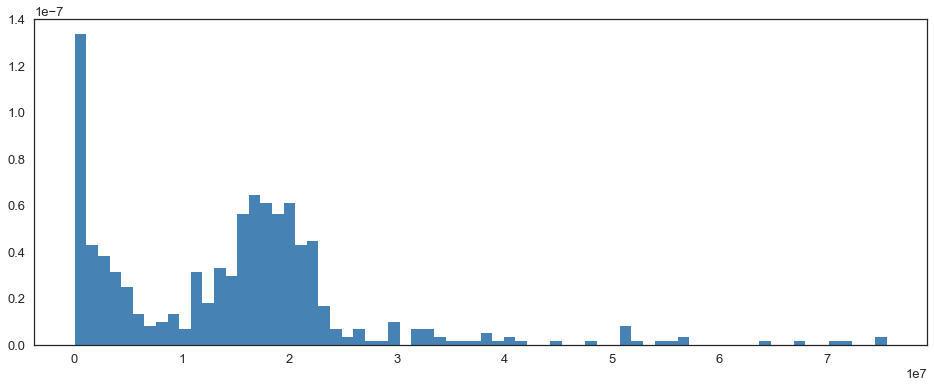

In [20]:
figsize(16, 6)
volumes = trap_volume_trace[:,2]
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [21]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
        return loss_s

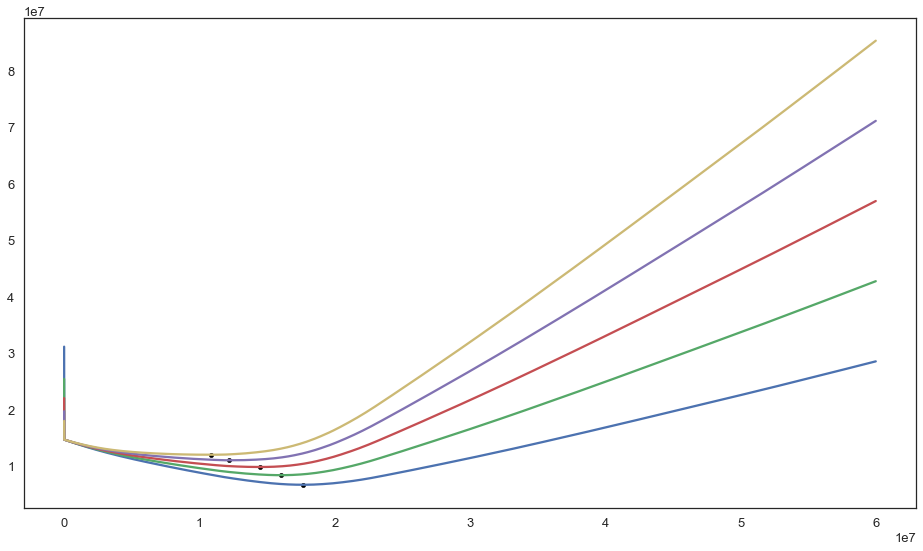

In [22]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [57]:
### TEST SITE ###

z_res_top =         res_unc_trace[3]
z_sec_res_top = sec_res_unc_trace[3]
z_seal_top =       seal_unc_trace[3]
z_over_top =       over_unc_trace[3]

Z-Variations: -0.00664907312593 

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarni

0.0173363471783 -0.0256033185731 0.0399614177262
Spill_Z: -1239.05502319
Leak_Z: -1284.55986023


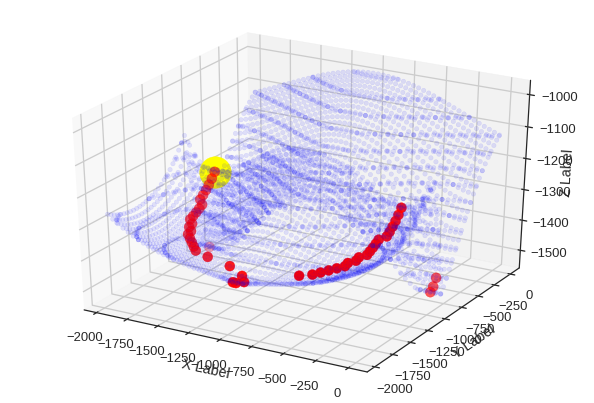

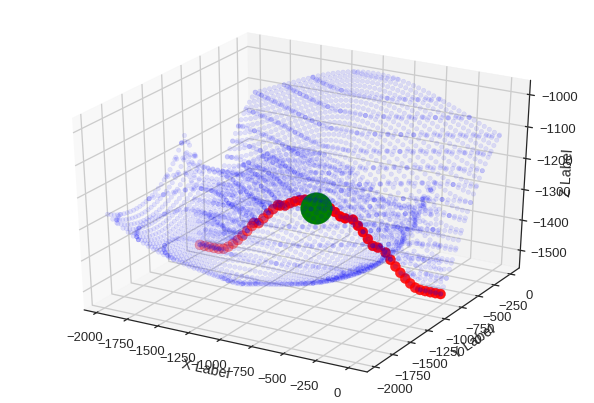

Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:159: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


VOLUME INCLUDING OUTSIDE TRAP: 8896000.0
TRAP FOUND 192
TRAP FOUND 189


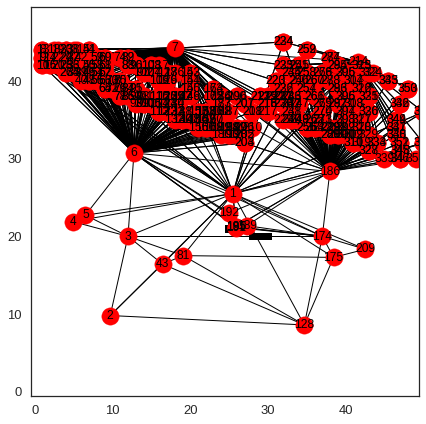

Maximum reservoir volume: 7360000.0 m³


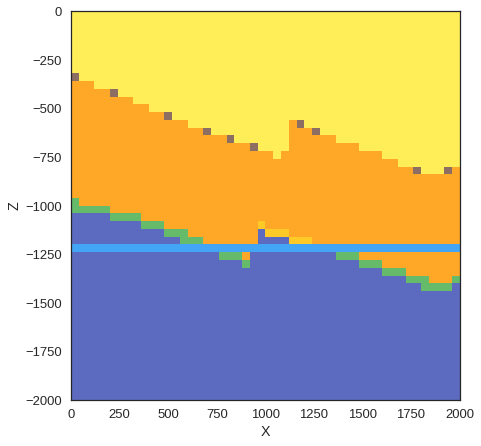

In [58]:
new_z_sec_res = sec_res_z + z_sec_res_top
new_z_seal = seal_z + z_seal_top
new_z_res = res_z + z_res_top
new_z_over = over_z + z_over_top

print('Z-Variations:', z_sec_res_top, z_seal_top, z_res_top, z_over_top)
interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'] = new_z_sec_res
interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z_seal
interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z_res
interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Overlying'] = new_z_base

sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)

res_surf, res_surf_simp = gp.get_surfaces(potential_block=sol[0, 1,:], 
                                      interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']),)

lith_block = sol[0, 0,:]
fault_block = sol[0, 2,:]

spill_z, spill_p, spill_line, spill_bottom = spill_point(res_surf)
leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surf)

print('Spill_Z:', spill_z)
print('Leak_Z:', leak_z)

plot_spill(res_surf, spill_line, spill_p)
plot_leak(res_surf, leak_line, leak_p)
        
max_vol, sol[0, 0,:], bottom, trap = max_res_vol(lith_block, fault_block, res_surf)

#plot_trap(res_surf, bottom, spill_p, leak_p)
#print("Bottom_Z:", bottom[1,2])

print("Maximum reservoir volume: %s m³" % max_vol)
gp.plot_section(geo_data, sol[0, 0,:], 25)